In [1]:
import os
import pandas
import json
import pickle

import numpy
import math
import scipy.stats
import scipy.ndimage

%matplotlib widget
import matplotlib
import matplotlib.pyplot
import seaborn

import datetime
import pytz

import activity_experiments_python.scenario_management as SFM
import activity_experiments_python.ampconfig_management as ACM
import activity_experiments_python.signalsconfig_management as SCM
import activity_experiments_python.actuation_management as AM

In [2]:
# CONSTANTS
FPS             = 30 # Hz
NB_ACTS         = 8
MAPPING         = {0:[0,0], 1:[0,1], 2:[0,2], 3:[0,3], 4:[1,3], 5:[1,2], 6:[1,1], 7:[1,0]}
MAPPING_PLOT    = {0:[1,0], 1:[1,1], 2:[1,2], 3:[1,3], 4:[0,3], 5:[0,2], 6:[0,1], 7:[0,0]}
ACTUATION_DUR   = 15 # secs

DATA_RECALCULATION = False
# PATHS
root_path = "/Users/matthieu/Documents/proto3/Graz2023/May/activity/continuous/"

conf_path = root_path + 'configs/'
amp_config_file = conf_path + 'amp2config/config.json'
sig_config_file = conf_path + 'signals/signals_config.json'
sce_alloc_file = root_path + 'processed_data/scenarios_allocation.json'

res_path = root_path + 'processed_data/acts/'
leds_res_path = res_path + 'leds/'
acts_res_path = res_path + 'acts/'

# CONFIGS
amp_conf        = ACM.extract_amp_config(amp_config_file)
sig_conf        = SCM.extract_signals_config(sig_config_file)

f = open(sce_alloc_file, "r")
sce_alloc = json.load(f)
f.close()


# DATA
file_list = [x for x in os.listdir(acts_res_path) if x.endswith('acts.pickle')]
exps_times_list = sorted(list(set([x.split('_')[0] for x in file_list])))

resdata = [] 
for exp_id, exp_time in enumerate(exps_times_list):
    datapt = {}
    datapt['time'] = pytz.utc.localize(datetime.datetime.strptime(exp_time[:-3], '%y%m%dT%H%M%S'))
    datapt['time_hr'] = exp_time
    datapt['act_path'] = acts_res_path
    datapt['led_path'] = leds_res_path
    for i in range(0, NB_ACTS+1):
        if i == NB_ACTS:
            ind = 'a'
        else :
            ind = str(i)
        datapt['z'+ind+'_actname'] = exp_time+'_z'+ind+'_acts.pickle'
    datapt['led0name'] = exp_time + '_led0.pickle'
    datapt['led1name'] = exp_time + '_led1.pickle'

    # print(sce_alloc[exp_time])
    sce = SFM.extract_scenario_data_from_log(root_path + sce_alloc[exp_time])
    trig0_val = numpy.min(sce[2])
    trig1_val = numpy.min(sce[3])
    
    datapt['trig0'] = trig0_val
    datapt['trig1'] = trig1_val
    if trig0_val == 11 :
        datapt['sig1'] = {}
        datapt['sig2'] = {}
    else :
        datapt['sig1'] = sig_conf['SB0'][str(trig0_val)]['1']
        datapt['sig2'] = sig_conf['SB0'][str(trig0_val)]['2']

    if trig1_val == 11 :
        datapt['sig3'] = {}
        datapt['sig4'] = {}
    else :
        datapt['sig3'] = sig_conf['SB1'][str(trig1_val)]['1']
        datapt['sig4'] = sig_conf['SB1'][str(trig1_val)]['2']

    list_of_freqs = []
    for i in range(0, 8):
        ind = str(i)
        datapt['z'+ind+'_sig'] = [x for x in amp_conf.keys() if i in amp_conf[x]][0]
        if not(datapt['z'+ind+'_sig'] == 'gnd') and not(datapt[datapt['z'+ind+'_sig']] == {}):
            datapt['z'+ind+'_freq'] = datapt[datapt['z'+ind+'_sig']]['frequency']
            list_of_freqs.append(datapt['z'+ind+'_freq'])
        else :
            datapt['z'+ind+'_freq'] = None

    if trig1_val*trig0_val == 121 :
        datapt['frequency'] = 'Ctrl'
    elif trig1_val >= trig0_val:
        datapt['frequency'] = sig_conf['SB0'][str(trig0_val)]
    else :
        datapt['frequency'] = sig_conf['SB1'][str(trig1_val)]
    
    # sanity check
    if len(set(list_of_freqs)) > 1:
        print('Multiple frequencies at the same time')
        datapt['frequency'] = 'Problem'
    elif len(set(list_of_freqs)) == 1:
        datapt['frequency'] = list_of_freqs[0]
    else :
        datapt['frequency'] = 'Ctrl'
        
    resdata.append(datapt)

metadata = pandas.DataFrame.from_dict(resdata)
metadata

,time,time_hr,act_path,led_path,z0_actname,z1_actname,z2_actname,z3_actname,z4_actname,z5_actname,...,z3_freq,z4_sig,z4_freq,z5_sig,z5_freq,z6_sig,z6_freq,z7_sig,z7_freq,frequency
0,2023-05-28 08:00:12+00:00,230528T080012UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080012UTC_z0_acts.pickle,230528T080012UTC_z1_acts.pickle,230528T080012UTC_z2_acts.pickle,230528T080012UTC_z3_acts.pickle,230528T080012UTC_z4_acts.pickle,230528T080012UTC_z5_acts.pickle,...,NaN,sig2,1750.0,sig2,1750.0,sig4,1750.0,sig4,1750.0,1750
1,2023-05-28 08:02:11+00:00,230528T080211UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080211UTC_z0_acts.pickle,230528T080211UTC_z1_acts.pickle,230528T080211UTC_z2_acts.pickle,230528T080211UTC_z3_acts.pickle,230528T080211UTC_z4_acts.pickle,230528T080211UTC_z5_acts.pickle,...,NaN,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,1500
2,2023-05-28 08:04:11+00:00,230528T080411UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080411UTC_z0_acts.pickle,230528T080411UTC_z1_acts.pickle,230528T080411UTC_z2_acts.pickle,230528T080411UTC_z3_acts.pickle,230528T080411UTC_z4_acts.pickle,230528T080411UTC_z5_acts.pickle,...,NaN,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,Ctrl
3,2023-05-28 08:06:11+00:00,230528T080611UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080611UTC_z0_acts.pickle,230528T080611UTC_z1_acts.pickle,230528T080611UTC_z2_acts.pickle,230528T080611UTC_z3_acts.pickle,230528T080611UTC_z4_acts.pickle,230528T080611UTC_z5_acts.pickle,...,1250.0,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,1250
4,2023-05-28 08:08:11+00:00,230528T080811UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080811UTC_z0_acts.pickle,230528T080811UTC_z1_acts.pickle,230528T080811UTC_z2_acts.pickle,230528T080811UTC_z3_acts.pickle,230528T080811UTC_z4_acts.pickle,230528T080811UTC_z5_acts.pickle,...,NaN,sig2,NaN,sig2,NaN,sig4,2000.0,sig4,2000.0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2023-06-12 10:10:11+00:00,230612T101011UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101011UTC_z0_acts.pickle,230612T101011UTC_z1_acts.pickle,230612T101011UTC_z2_acts.pickle,230612T101011UTC_z3_acts.pickle,230612T101011UTC_z4_acts.pickle,230612T101011UTC_z5_acts.pickle,...,NaN,sig2,1500.0,sig2,1500.0,sig4,1500.0,sig4,1500.0,1500
803,2023-06-12 10:12:11+00:00,230612T101211UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101211UTC_z0_acts.pickle,230612T101211UTC_z1_acts.pickle,230612T101211UTC_z2_acts.pickle,230612T101211UTC_z3_acts.pickle,230612T101211UTC_z4_acts.pickle,230612T101211UTC_z5_acts.pickle,...,1000.0,sig2,1000.0,sig2,1000.0,sig4,1000.0,sig4,1000.0,1000
804,2023-06-12 10:14:11+00:00,230612T101411UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101411UTC_z0_acts.pickle,230612T101411UTC_z1_acts.pickle,230612T101411UTC_z2_acts.pickle,230612T101411UTC_z3_acts.pickle,230612T101411UTC_z4_acts.pickle,230612T101411UTC_z5_acts.pickle,...,NaN,sig2,1750.0,sig2,1750.0,sig4,NaN,sig4,NaN,1750
805,2023-06-12 10:16:11+00:00,230612T101611UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101611UTC_z0_acts.pickle,230612T101611UTC_z1_acts.pickle,230612T101611UTC_z2_acts.pickle,230612T101611UTC_z3_acts.pickle,230612T101611UTC_z4_acts.pickle,230612T101611UTC_z5_acts.pickle,...,1250.0,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,1250


In [3]:
def euclidean_dist(x, y):
    return (x[0]-y[0])**2 + (x[1]-y[1])**2

def find_closest_act(dtpt, i_act):
    dist_init = 100
    closest_act = 10
    for i in range(NB_ACTS):
        ind = str(i)
        if dtpt['act_z'+ind] == 1 :
            dist = euclidean_dist(MAPPING[i_act], MAPPING[i])
            if dist < dist_init :
                closest_act = i
                dist_init = dist
                
    return closest_act, dist_init

In [4]:
# Activity computation
long_interval_length    = 15 # seconds 
short_interval_length   = 1 # seconds 

NORMALIZATION_TYPE = 'first' # 'max' # 

lil_dt = datetime.timedelta(seconds=long_interval_length)
sil_dt = datetime.timedelta(seconds=short_interval_length)

if DATA_RECALCULATION : 
    fields_to_keep = ['time', 'time_hr', 'frequency', 'trig0', 'trig1']
    resdata = []
    for exp_id, exp in metadata.iterrows():
        datapoint = {}
        for key in fields_to_keep:
            datapoint[key] = exp[key]

        sum_acts = 0
        for i in range(0, NB_ACTS):
            if not(math.isnan(exp['z'+str(i)+'_freq'])):
                datapoint['act_z'+str(i)] = 1
                sum_acts += 1
            else :
                datapoint['act_z'+str(i)] = 0
        for i in range(0, NB_ACTS):
            close_act, dist = find_closest_act(datapoint, i)
            datapoint['act_z'+str(i)+'_closest_act_dist'] = dist
            if datapoint['trig0'] == 11 and datapoint['trig1'] == 11:
                datapoint['act_z'+str(i)+'_closest_act_dist'] = 'ctrl'
        
        datapoint['nb_acts_active'] = sum_acts
        led0_signal = pandas.read_pickle(exp.led_path + exp.led0name)
        led1_signal = pandas.read_pickle(exp.led_path + exp.led1name)
        
        sce = SFM.extract_scenario_data_from_log(root_path + sce_alloc[datapoint['time_hr']])

        if exp.trig0*exp.trig1 == 121:
            ts = 0
            ct = 17
        elif exp.trig0 == 11:
            ts = SFM.compute_time_shift(led1_signal.value, sce[1], plot=False, save_plot_fname=None, fps=FPS)
            ct = 1/FPS*next((i for i, x in enumerate(list(sce[1])) if x==0), None) + ts/FPS
        elif exp.trig1 == 11:
            ts = SFM.compute_time_shift(led0_signal.value, sce[0], plot=False, save_plot_fname=None, fps=FPS)
            ct = 1/FPS*next((i for i, x in enumerate(list(sce[0])) if x==0), None) + ts/FPS
        else:
            ts0 = SFM.compute_time_shift(led0_signal.value, sce[0], plot=False, save_plot_fname=None, fps=FPS)
            ts1 = SFM.compute_time_shift(led1_signal.value, sce[1], plot=False, save_plot_fname=None, fps=FPS)
            ts = (ts0 + ts1) / 2
            ct = 1/FPS*next((i for i, x in enumerate(list(sce[0])) if x==0), None) + ts/FPS

        datapoint['timeshift'] = ts
        datapoint['change_time_on'] = datapoint['time'] + datetime.timedelta(seconds=ct)
        datapoint['change_time_off'] = datapoint['time'] + datetime.timedelta(seconds=ct+15)

        for i in range(0, NB_ACTS):
            ind = str(i)
            act_signal = pandas.read_pickle(exp.act_path + exp['z'+ind+'_actname'])

            # 15 minutes analysis ! 
            # Before actuation
            actsignal_B = act_signal[(act_signal.local_ts > datapoint['change_time_on']-lil_dt)]
            actsignal_B = actsignal_B[(actsignal_B.local_ts < datapoint['change_time_on'])]

            # During actuation
            actsignal_D = act_signal[(act_signal.local_ts > datapoint['change_time_on'])]
            actsignal_D = actsignal_D[(actsignal_D.local_ts < datapoint['change_time_off'])]

            # Right after actuation
            actsignal_A1 = act_signal[(act_signal.local_ts > datapoint['change_time_off'])]
            actsignal_A1 = actsignal_A1[(actsignal_A1.local_ts < datapoint['change_time_off']+lil_dt)]

            # moments after actuation
            actsignal_A2 = act_signal[(act_signal.local_ts > datapoint['change_time_off']+lil_dt)]
            actsignal_A2 = actsignal_A2[(actsignal_A2.local_ts < datapoint['change_time_off']+2*lil_dt)]

            datapoint['z'+ind+'_B_ave']     = actsignal_B.value.mean()
            datapoint['z'+ind+'_D_ave']     = actsignal_D.value.mean()
            datapoint['z'+ind+'_A1_ave']    = actsignal_A1.value.mean()
            datapoint['z'+ind+'_A2_ave']    = actsignal_A2.value.mean()

            datapoint['z'+ind+'_relative_D']    = datapoint['z'+ind+'_D_ave'] / datapoint['z'+ind+'_B_ave']
            datapoint['z'+ind+'_relative_A1']   = datapoint['z'+ind+'_A1_ave'] / datapoint['z'+ind+'_B_ave']
            datapoint['z'+ind+'_relative_A2']   = datapoint['z'+ind+'_A2_ave'] / datapoint['z'+ind+'_B_ave']

            # 5 minutes bins
            all_bins_vals = []
            for j in range(-15, 45): # number of 5 secs bins in a minute
                act_signal_bin = act_signal[(act_signal.local_ts > datapoint['change_time_on']+j*sil_dt)]
                act_signal_bin = act_signal_bin[(act_signal_bin.local_ts < datapoint['change_time_on']+(j+1)*sil_dt)]
                datapoint['z'+ind+'_bin'+str(j+15)+'_ave'] = act_signal_bin.value.mean()
                all_bins_vals.append(act_signal_bin.value.mean())
            all_bins_vals = numpy.array(all_bins_vals)
            # all_bins_vals = all_bins_vals-numpy.min(all_bins_vals)
            # all_bins_vals = all_bins_vals/numpy.max(all_bins_vals)
            if NORMALIZATION_TYPE == 'first':
                all_bins_vals = all_bins_vals/all_bins_vals[0]
            else :
                all_bins_vals = all_bins_vals/numpy.max(all_bins_vals)
            for j in range(-15, 45):
                datapoint['z'+ind+'_bin'+str(j+15)+'_rel'] =  all_bins_vals[j+15]

        
        # print(datapoint)
        resdata.append(datapoint)

    data = pandas.DataFrame.from_dict(resdata)
    pandas.to_pickle(data, root_path+'activity_1s_bins.pickle')
else :
    data=pandas.read_pickle(root_path+'activity_1s_bins.pickle')
data

,time,time_hr,frequency,trig0,trig1,act_z0,act_z1,act_z2,act_z3,act_z4,...,z7_bin50_rel,z7_bin51_rel,z7_bin52_rel,z7_bin53_rel,z7_bin54_rel,z7_bin55_rel,z7_bin56_rel,z7_bin57_rel,z7_bin58_rel,z7_bin59_rel
0,2023-05-28 08:00:12+00:00,230528T080012UTC,1750,8,8,0,0,0,0,1,...,1.415325,1.146413,1.605661,1.272816,1.115178,2.156662,1.902879,1.554417,1.311371,1.088824
1,2023-05-28 08:02:11+00:00,230528T080211UTC,1500,2,11,1,1,0,0,0,...,1.596943,1.281577,1.420756,2.177796,1.145615,1.763475,2.284795,1.423170,1.427192,1.638777
2,2023-05-28 08:04:11+00:00,230528T080411UTC,Ctrl,11,11,0,0,0,0,0,...,2.366165,1.339900,1.184241,0.855156,1.223638,0.719583,0.772113,0.918115,1.127462,1.030900
3,2023-05-28 08:06:11+00:00,230528T080611UTC,1250,11,1,0,0,1,1,0,...,0.970318,1.244583,1.041555,0.761354,0.665776,0.626892,1.013060,0.752449,0.739389,0.856634
4,2023-05-28 08:08:11+00:00,230528T080811UTC,2000,4,9,1,1,0,0,0,...,0.725505,0.696834,0.641237,0.720768,0.796061,0.956869,0.571678,0.456744,0.373224,0.444528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2023-06-12 10:10:11+00:00,230612T101011UTC,1500,7,7,0,0,0,0,1,...,0.426425,0.445498,0.386787,0.565051,0.470858,0.581993,0.780714,0.606393,0.422376,0.604262
803,2023-06-12 10:12:11+00:00,230612T101211UTC,1000,10,10,1,1,1,1,1,...,0.958026,0.942056,0.764947,0.875512,0.783989,0.791769,0.695536,0.765561,0.931204,0.827191
804,2023-06-12 10:14:11+00:00,230612T101411UTC,1750,8,11,0,0,0,0,1,...,1.131915,1.116744,0.833858,0.589269,0.570028,1.143016,0.889732,1.146531,0.995375,1.074376
805,2023-06-12 10:16:11+00:00,230612T101611UTC,1250,1,1,1,1,1,1,0,...,1.541410,1.176425,1.621533,1.388290,1.688559,1.691641,1.191256,1.790639,1.427388,1.188174


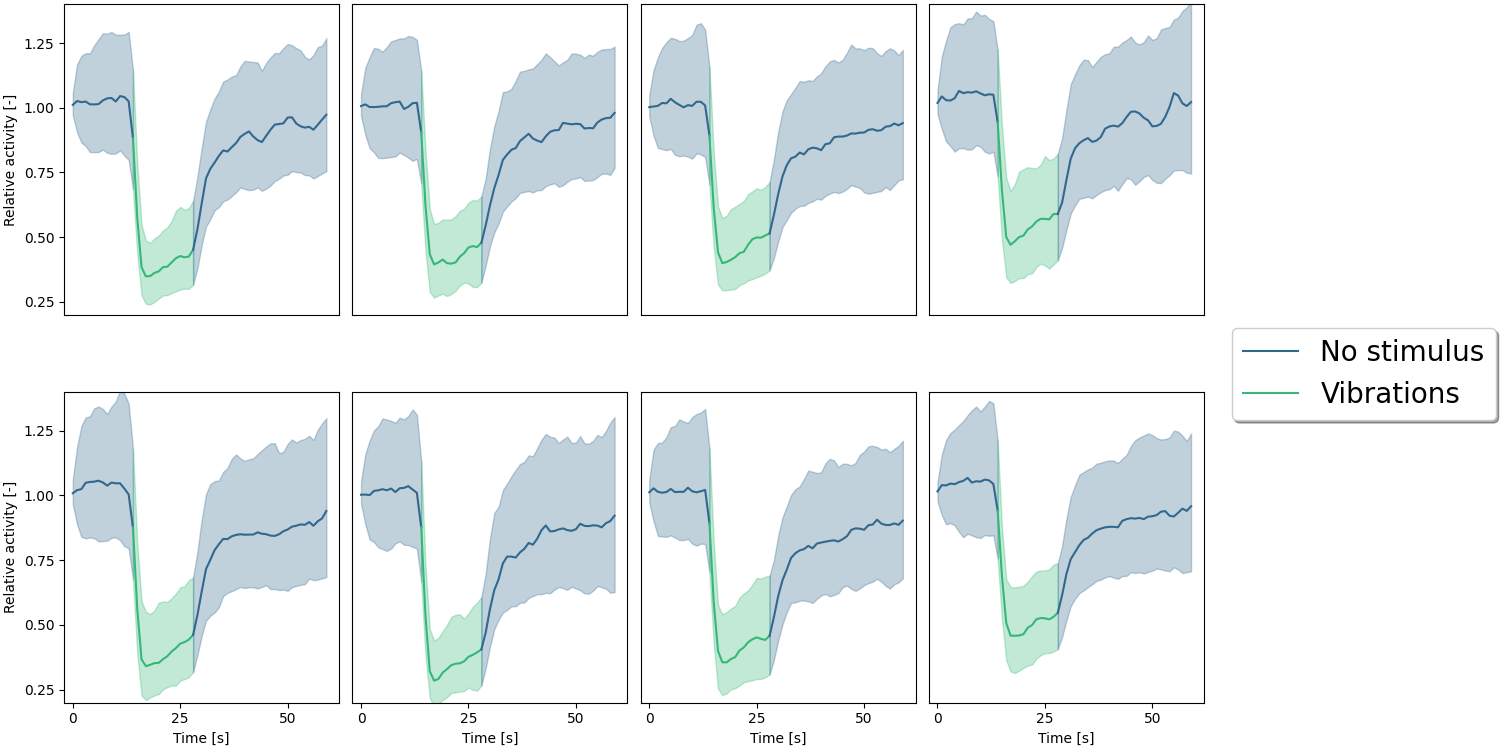

In [5]:
fig, ax = matplotlib.pyplot.subplots(2, 4, figsize=(15, 7.5), constrained_layout=True)

matplotlib.rcParams.update({'font.size': 20})

dataset = data[data.nb_acts_active != 0]

for act in range(NB_ACTS):
    ind = str(act)
    data_to_consider = dataset[dataset['act_z'+ind+'_closest_act_dist'] == 0]

    medians = []
    q1s = []
    q3s = []
    for j in range(-15, 45):
        medians.append(data_to_consider['z'+ind+'_bin'+str(j+15)+'_rel'].median())
        q1s.append(data_to_consider['z'+ind+'_bin'+str(j+15)+'_rel'].quantile(0.25))
        q3s.append(data_to_consider['z'+ind+'_bin'+str(j+15)+'_rel'].quantile(0.75))

    medians = numpy.array(medians)
    q1s = numpy.array(q1s)
    q3s = numpy.array(q3s)

    # Filtering
    SIGMA_GAUSSIAN = 0.75
    medians = scipy.ndimage.gaussian_filter(medians, sigma=SIGMA_GAUSSIAN)
    q1s = scipy.ndimage.gaussian_filter(q1s, sigma=SIGMA_GAUSSIAN)
    q3s = scipy.ndimage.gaussian_filter(q3s, sigma=SIGMA_GAUSSIAN)

    # Coloring
    boundaries = [15, 29]
    time_vector = numpy.array(range(60))
    COLOR_CTRL = '#31688e'
    COLOR_VIBS = '#35b779'

    if act not in [0, 1, 2, 3]:
        ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].get_xaxis().set_ticks([])
    else :
        ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlabel('Time [s]')
    if act not in [0, 7]:
        ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].get_yaxis().set_ticks([])
    else :
        ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylabel('Relative activity [-]')

    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlim([-2, 62])
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylim([0.2, 1.4])

    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].plot(time_vector[:boundaries[0]], medians[:boundaries[0]], c=COLOR_CTRL, label='No stimulus')
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].plot(time_vector[boundaries[0]-1:boundaries[1]], medians[boundaries[0]-1:boundaries[1]], c=COLOR_VIBS, label='Vibrations')
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].plot(time_vector[boundaries[1]-1:], medians[boundaries[1]-1:], c=COLOR_CTRL)


    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].fill_between(time_vector[:boundaries[0]], q1s[:boundaries[0]], q3s[:boundaries[0]], color=COLOR_CTRL, alpha=0.3)
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].fill_between(time_vector[boundaries[0]-1:boundaries[1]], q1s[boundaries[0]-1:boundaries[1]], q3s[boundaries[0]-1:boundaries[1]], color=COLOR_VIBS, alpha=0.3)
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].fill_between(time_vector[boundaries[1]-1:], q1s[boundaries[1]-1:], q3s[boundaries[1]-1:], color=COLOR_CTRL, alpha=0.3)
    
ax[1,3].legend(loc='upper left', bbox_to_anchor=(1.05, 1.25), fancybox=True, shadow=True)
fig.savefig('/Users/matthieu/Documents/papers/2024/Hardware/media/graphs/activity_effect.png', transparent=True)
# Control plot
# fig, ax = matplotlib.pyplot.subplots(2, 4, figsize=(15, 6), sharex=True, sharey=True, constrained_layout=True)

# dataset = data[data.nb_acts_active == 0]

# for act in range(NB_ACTS):
#     ind = str(act)
#     data_to_consider = dataset[dataset['act_z'+ind+'_closest_act_dist'] == 0]

#     for j in range(-15, 45):
#         _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].boxplot(dataset['z'+ind+'_bin'+str(j+15)+'_rel'].values, positions=[(j+15)*1], widths=[3])

#     # Stat tests
#     RStest_in   = scipy.stats.ranksums(dataset['z'+ind+'_bin'+str(2)+'_rel'], dataset['z'+ind+'_bin'+str(3)+'_rel'])
#     RStest_out  = scipy.stats.ranksums(dataset['z'+ind+'_bin'+str(5)+'_rel'], dataset['z'+ind+'_bin'+str(6)+'_rel'])
    # print(ind, RStest_in[1], RStest_out[1], len(dataset['z'+ind+'_bin'+str(2)+'_rel']))

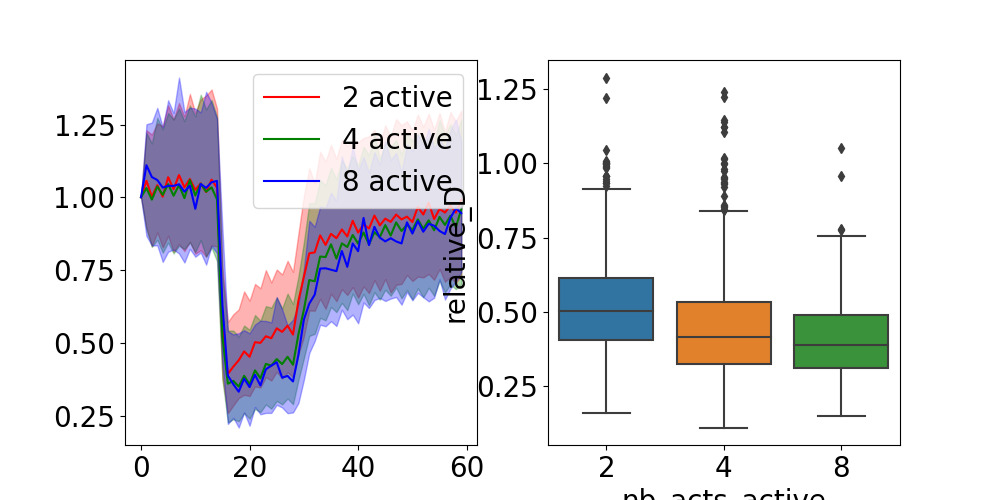

In [6]:
# Typical 2-4-8

data_complete = []
for exp_id, exp in data.iterrows():
    for act in range(8):
        ind = str(act)

        dp = {}
        dp['time']      = exp.time 
        dp['time_hr']   = exp.time_hr 
        dp['frequency'] = exp.frequency 
        dp['trig0']     = exp.trig0 
        dp['trig1']     = exp.trig1 

        dp['nb_acts_active']    = exp.nb_acts_active
        dp['act']               = exp['act_z'+ind] 
        dp['closest_act_dist']  = exp['act_z'+ind+'_closest_act_dist'] 

        if dp['closest_act_dist'] == 'ctrl':
            dp['closest_act_category'] = dp['closest_act_dist']
        elif dp['closest_act_dist'] <= 1  :
            dp['closest_act_category'] = dp['closest_act_dist']
        else : 
            dp['closest_act_category'] = '>1'

        for key in list(data.columns):
            if key.startswith('z'+ind):
                dp[key[3:]] = exp[key]
        
        data_complete.append(dp)

data_complete = pandas.DataFrame.from_dict(data_complete)


dataset = data_complete[data_complete.closest_act_dist == 0]
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(10,5))
colors = ['r', 'g', 'b']
for ind, nb_act in enumerate([2, 4, 8]):
    data_act = dataset[dataset.nb_acts_active == nb_act]
    
    medians = []
    q1s = []
    q3s = []
    for j in range(-15, 45):
        medians.append(data_act['bin'+str(j+15)+'_rel'].median())
        q1s.append(data_act['bin'+str(j+15)+'_rel'].quantile(0.25))
        q3s.append(data_act['bin'+str(j+15)+'_rel'].quantile(0.75))

    ax[0].plot(time_vector, medians, c=colors[ind], label='{} active'.format(nb_act))
    ax[0].fill_between(time_vector, q1s, q3s, color=colors[ind], alpha=0.3)
ax[0].legend()


_ = seaborn.boxplot(data=dataset, x="nb_acts_active", y="relative_D", ax=ax[1])


In [7]:
_ = [print(key) for key in list(data_complete.columns)]

time
time_hr
frequency
trig0
trig1
nb_acts_active
act
closest_act_dist
closest_act_category
B_ave
D_ave
A1_ave
A2_ave
relative_D
relative_A1
relative_A2
bin0_ave
bin1_ave
bin2_ave
bin3_ave
bin4_ave
bin5_ave
bin6_ave
bin7_ave
bin8_ave
bin9_ave
bin10_ave
bin11_ave
bin12_ave
bin13_ave
bin14_ave
bin15_ave
bin16_ave
bin17_ave
bin18_ave
bin19_ave
bin20_ave
bin21_ave
bin22_ave
bin23_ave
bin24_ave
bin25_ave
bin26_ave
bin27_ave
bin28_ave
bin29_ave
bin30_ave
bin31_ave
bin32_ave
bin33_ave
bin34_ave
bin35_ave
bin36_ave
bin37_ave
bin38_ave
bin39_ave
bin40_ave
bin41_ave
bin42_ave
bin43_ave
bin44_ave
bin45_ave
bin46_ave
bin47_ave
bin48_ave
bin49_ave
bin50_ave
bin51_ave
bin52_ave
bin53_ave
bin54_ave
bin55_ave
bin56_ave
bin57_ave
bin58_ave
bin59_ave
bin0_rel
bin1_rel
bin2_rel
bin3_rel
bin4_rel
bin5_rel
bin6_rel
bin7_rel
bin8_rel
bin9_rel
bin10_rel
bin11_rel
bin12_rel
bin13_rel
bin14_rel
bin15_rel
bin16_rel
bin17_rel
bin18_rel
bin19_rel
bin20_rel
bin21_rel
bin22_rel
bin23_rel
bin24_rel
bin25_rel
bin26_r